In [69]:
import sys
sys.path.append('C:/Users/User/Documents/Duke/Acquisition-Code/Modules')
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import probe_deconvolve as pd
import propagation_functions as pf

mm = .001

In [70]:
mat = scipy.io.loadmat('C:/Users/User/Documents/Duke/Projects/DARPA/Data/Mike_Antenna/Near Field Scans/Mike_Antenna_2022-02-10.mat')
mat.keys()
X = mat['X']
Y = mat['Y']
x = np.unique(X)
y = np.unique(Y)
f = mat['f'][0,:]
measurements = mat['measurements']
measurements_corrected = mat['measurements_corrected']
Theta_far = mat['Theta_far']
Phi_far = mat['Phi_far']
E_far = mat['E_far']

E_int = np.abs(np.sum(E_far * np.conjugate(E_far), 4)).astype(np.float32)

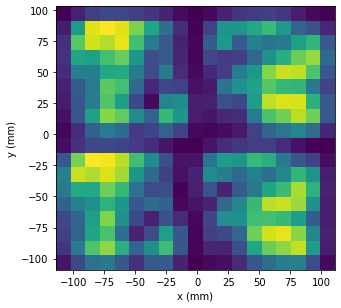

C:\Users\User\anaconda3\envs\duke\lib\site-packages\matplotlib\transforms.py:2663: RuntimeWarning: divide by zero encountered in double_scalars
  y_scale = 1.0 / inh
C:\Users\User\anaconda3\envs\duke\lib\site-packages\matplotlib\transforms.py:2665: RuntimeWarning: invalid value encountered in double_scalars
  [0.0    , y_scale, (-inb*y_scale)],
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


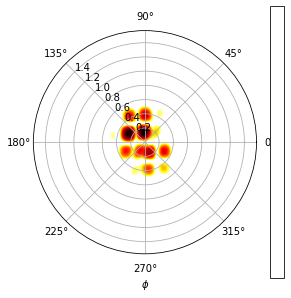

In [71]:
f_indx = np.argmin(np.abs(f - 10E9))
m_indx = 0

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.imshow(np.abs(measurements_corrected[:,:,0,0,0]), extent=(np.min(X), np.max(X), np.min(Y), np.max(Y)))
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
plt.show()

fig, ax2 = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(5,5))
cs = ax2.contourf(Phi_far, Theta_far, 10*np.log10(E_int[:,:,f_indx,m_indx]/np.amax(E_int[:,:,f_indx,m_indx])), 
            np.linspace(-15, 0, 50), 
            cmap=plt.cm.hot_r)
ax2.grid(True)
ax2.set_rlabel_position(135)
fig.colorbar(cs, ticks=np.linspace(-15, 0, 7))
plt.xlabel('$\phi$')
plt.show()

In [29]:
N_theta = 180
N_phi = 180

Theta_far, Phi_far, E_far_test = pf.propagate_from_scans(measurements_corrected[:,:,f_indx,m_indx,:], f[f_indx], X*mm, Y*mm, N_theta, N_phi)
E_int_test = np.abs(np.sum(E_far_test * np.conjugate(E_far_test), 2)).astype(np.float32)

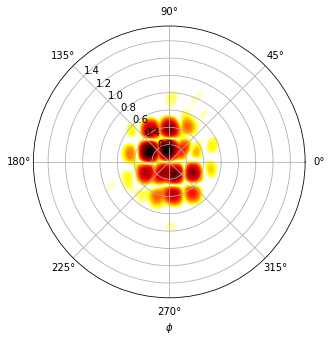

In [32]:
fig, ax2 = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(5,5))
cs = ax2.contourf(Phi_far, Theta_far, 10*np.log10(E_int_test[:,:]/np.amax(E_int_test[:,:])), 
            np.linspace(-25, 0, 50), 
            cmap=plt.cm.hot_r)
ax2.grid(True)
ax2.set_rlabel_position(135)
# fig.colorbar(cs, ticks=np.linspace(-15, 0, 7))
plt.xlabel('$\phi$')
plt.show()

In [117]:
c = scipy.constants.c

def spherical_to_cartesian_vector(vec, theta_list, phi_list):
    # vec n X 3, theta_list n X 1, phi_list n X 1
    if np.isscalar(theta_list):
        n = 1
    else:
        n = phi_list.size
    T = np.reshape(np.column_stack((
        np.sin(theta_list)*np.cos(phi_list), 
        np.cos(theta_list)*np.cos(phi_list),
        -np.sin(phi_list),
        np.sin(theta_list)*np.sin(phi_list),
        np.cos(theta_list)*np.sin(phi_list),
        np.cos(phi_list),
        np.cos(theta_list),
        -np.sin(theta_list),
        np.zeros(n))),
              (n, 3, 3))
    return np.matmul(T, vec[:,:,None])[:,:,0]

def make_A_mat(f, a, b, x_probe, y_probe, z_offset):
    k = 2*np.pi*f/c
    beta = k*np.sqrt(1-(np.pi/(k*a))**2)
    
    X_probe, Y_probe = np.meshgrid(x_probe, y_probe, indexing='ij')
    
    X = X_probe
    Y = Y_probe
    x = np.unique(X_probe)
    y = np.unique(Y_probe)
    
    E_vertical = np.empty((x_probe.size, y_probe.size, x.size, y.size, 2), dtype=np.complex128)
    
    for i in range(x_probe.size):
        for j in range(y_probe.size):
            
            ## defining spherical coordinates over plane, for gain pattern calculation
            r = np.sqrt((X - X_probe[i,j])**2 + (Y - Y_probe[i,j])**2 + z_offset**2)
            theta = np.arccos(z_offset/np.sqrt((X - X_probe[i,j])**2 + (Y - Y_probe[i,j])**2 + (z_offset)**2))
            phi = np.arctan2(Y - Y_probe[i,j], X - X_probe[i,j])
            
            Ee = ( ((1+beta/k*np.cos(theta))/(1+beta/k)) *
                  (np.sin(k*b/2 * np.sin(theta))/((k*b/2)*np.sin(theta))) )
            Eh = ( (np.pi/2)**2 * np.cos(theta) 
                  * np.cos(k*a/2 * np.sin(theta))/((np.pi/2)**2 - (k*a/2*np.sin(theta))**2) )
            
            ## removing nan at probe position, replacing with max value 
            ## (sort gives nan as max value, taking next highest)
            Ee = np.nan_to_num(Ee, nan=np.sort(Ee.reshape(-1))[-2])
            Eh = np.nan_to_num(Eh, nan=np.sort(Eh.reshape(-1))[-2])
            
            E_theta = np.exp(1j*k*r)/(k*r) * Ee * np.sin(phi)
            E_phi = np.exp(1j*k*r)/(k*r) * Eh * np.cos(phi)
    
            E_vec_spherical = np.stack(
                (np.zeros(E_theta.shape),
                 E_theta,
                 E_phi), axis=2).reshape((-1, 3))
            
            ## convert spherical vector components to cartesian
            E_vec_cartesian = spherical_to_cartesian_vector(E_vec_spherical,
                                                            theta.reshape(-1),
                                                            phi.reshape(-1))
            
            E_vertical[i,j,:,:,:] = E_vec_cartesian[:,:2].reshape((X.shape[0], Y.shape[1], 2))

    # e-field components for horizontal orientation obtained by swapping vertical orientation components
    E_horizontal = np.empty(E_vertical.shape, dtype=np.complex128)
    E_horizontal[:,:,:,:,0] = E_vertical[:,:,:,:,1]
    E_horizontal[:,:,:,:,1] = E_vertical[:,:,:,:,0]
    
    A_mat = np.concatenate((np.reshape(E_horizontal, (x_probe.size*y_probe.size, x.size*y.size, 2)),
                        np.reshape(E_vertical, (x_probe.size*y_probe.size, x.size*y.size, 2))),
                       axis=0)
    A_mat = np.concatenate((A_mat[:,:,0], A_mat[:,:,1]), axis=1)
    return E_vertical, A_mat

def probe_deconvolve(measurements, A_mat, x_probe, y_probe):
    ## measurements: Nx x Ny x 2 array
    ## size 2 dimension corresponds to vertical-horizontal probe orientation
    
    g = measurements.reshape((x_probe.size*y_probe.size*2, 1))
    # E_solution = np.matmul(np.linalg.inv(A_mat), g)
    E_solution = np.matmul(np.conjugate(np.transpose(A_mat)), g)
    # E_solution = np.matmul(np.linalg.pinv(A_mat, .001), g)
    # E_solution = np.linalg.inv(A_mat.T @ A_mat)@A_mat.T@g
    
    return E_solution.reshape((x_probe.size, y_probe.size, 2))

C:\Users\User\AppData\Local\Temp/ipykernel_37280/2627275236.py:44: RuntimeWarning: invalid value encountered in true_divide
  (np.sin(k*b/2 * np.sin(theta))/((k*b/2)*np.sin(theta))) )


(684, 684)


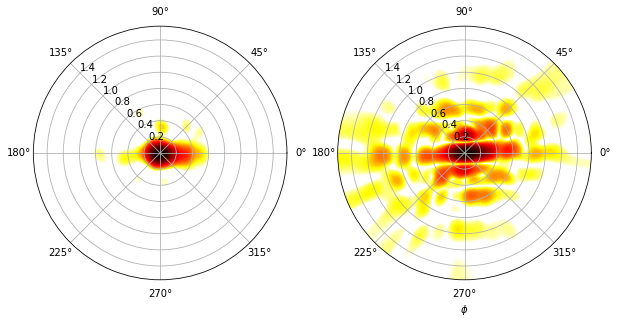

In [119]:
a_probe = 22.86
b_probe = 10.16
d = 85

E_vertical, A_mat = make_A_mat(f[f_indx], a_probe*mm, b_probe*mm, x*mm, y*mm, d*mm)

print(A_mat.shape)
# plt.imshow(np.sum(np.abs(E_vertical[-1,-1,:,:,:]), axis=2))
# plt.imshow(np.abs(E_vertical[10,10,:,:,1]))
# plt.colorbar()

# plt.imshow(np.abs(A_mat[:,:,0]))

Theta_far, Phi_far, E_far_test_uncorrected = pf.propagate_from_scans(measurements[:,:,f_indx,m_indx,:], f[f_indx], X*mm, Y*mm, N_theta, N_phi)
E_int_test_uncorrected = np.abs(np.sum(E_far_test_uncorrected * np.conjugate(E_far_test_uncorrected), 2)).astype(np.float32)

measurements_corrected = np.transpose(probe_deconvolve(np.transpose(measurements[:,:,f_indx,m_indx,:], (1,0,2)), A_mat, x*mm, y*mm), (1,0,2))
Theta_far, Phi_far, E_far_test = pf.propagate_from_scans(measurements_corrected, f[f_indx], X*mm, Y*mm, N_theta, N_phi)
E_int_test = np.abs(np.sum(E_far_test * np.conjugate(E_far_test), 2)).astype(np.float32)

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='polar'), figsize=(10,5))
cs = ax1.contourf(Phi_far, Theta_far, 10*np.log10(E_int_test_uncorrected[:,:]/np.amax(E_int_test_uncorrected[:,:])), 
            np.linspace(-15, 0, 50), 
            cmap=plt.cm.hot_r)
ax1.grid(True)
ax1.set_rlabel_position(135)
cs = ax2.contourf(Phi_far, Theta_far, 10*np.log10(E_int_test[:,:]/np.amax(E_int_test[:,:])), 
            np.linspace(-30, 0, 50), 
            cmap=plt.cm.hot_r)
ax2.grid(True)
ax2.set_rlabel_position(135)
# fig.colorbar(cs, ticks=np.linspace(-15, 0, 7))
plt.xlabel('$\phi$')
plt.show()

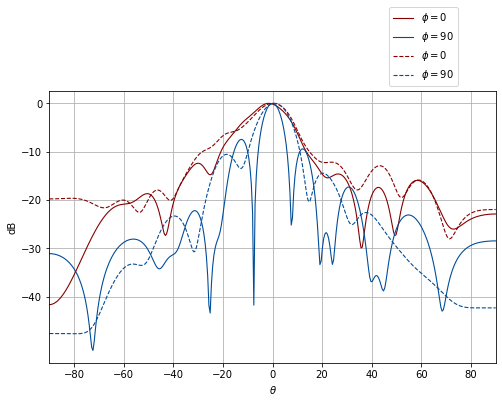

In [104]:
E_plot_test = np.reshape(E_int_test, Theta_far.shape)
E_plot_test_uncorrected = np.reshape(E_int_test_uncorrected, Theta_far.shape)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

theta_plot0 = np.concatenate((np.flip(E_plot_test[1:,0][:,None]), E_plot_test[:,int(N_phi/2)][:,None]))
theta_plot90 = np.concatenate((np.flip(E_plot_test[1:,int(N_phi/4)][:,None]), E_plot_test[:,3*int(N_phi/4)][:,None]))
theta_plot0_uncorrected = np.concatenate((np.flip(E_plot_test_uncorrected[1:,0][:,None]), E_plot_test_uncorrected[:,int(N_phi/2)][:,None]))
theta_plot90_uncorrected = np.concatenate((np.flip(E_plot_test_uncorrected[1:,int(N_phi/4)][:,None]), E_plot_test_uncorrected[:,3*int(N_phi/4)][:,None]))

ax.plot(np.degrees(np.linspace(-np.pi/2, np.pi/2, theta_plot0.size)), 
        10*np.log10(theta_plot0/np.amax(theta_plot0)), 
        label=r'$\phi=0$',
        color=(0.53,0.0,0.0),
         linewidth=1.1)
ax.plot(np.degrees(np.linspace(-np.pi/2, np.pi/2, theta_plot90.size)), 
        10*np.log10(theta_plot90/np.amax(theta_plot90)), 
        label=r'$\phi=90$',
        color=(0,.3,.6),
         linewidth=1.1)
ax.plot(np.degrees(np.linspace(-np.pi/2, np.pi/2, theta_plot0_uncorrected.size)), 
        10*np.log10(theta_plot0_uncorrected/np.amax(theta_plot0_uncorrected)), 
        '--',
        label=r'$\phi=0$',
        color=(0.53,0.0,0.0),
         linewidth=1.1)
ax.plot(np.degrees(np.linspace(-np.pi/2, np.pi/2, theta_plot90_uncorrected.size)), 
        10*np.log10(theta_plot90_uncorrected/np.amax(theta_plot90_uncorrected)), 
        '--',
        label=r'$\phi=90$',
        color=(0,.3,.6),
         linewidth=1.1)
ax.set_ylabel('dB')
ax.set_xlabel(r'$\theta$')
ax.set_yticks([-40, -30, -20, -10, 0])
ax.set_xlim(-90, 90)
ax.legend(frameon=True, bbox_to_anchor=(0.75, 1))
ax.grid(visible=True, which='major')
plt.show()

10345055577.91777


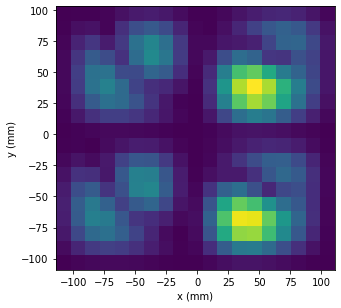

In [88]:
print(np.linalg.cond(A_mat))

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.imshow(np.abs(measurements_corrected[:,:,1]), extent=(np.min(X), np.max(X), np.min(Y), np.max(Y)))
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
plt.show()

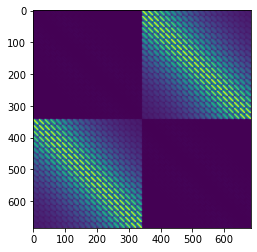